<a href="https://colab.research.google.com/github/claudioquevedo/Pos-Graduacao-em-IA/blob/master/PLN_e_L%C3%B3gica_Fuzi_Trabalho_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

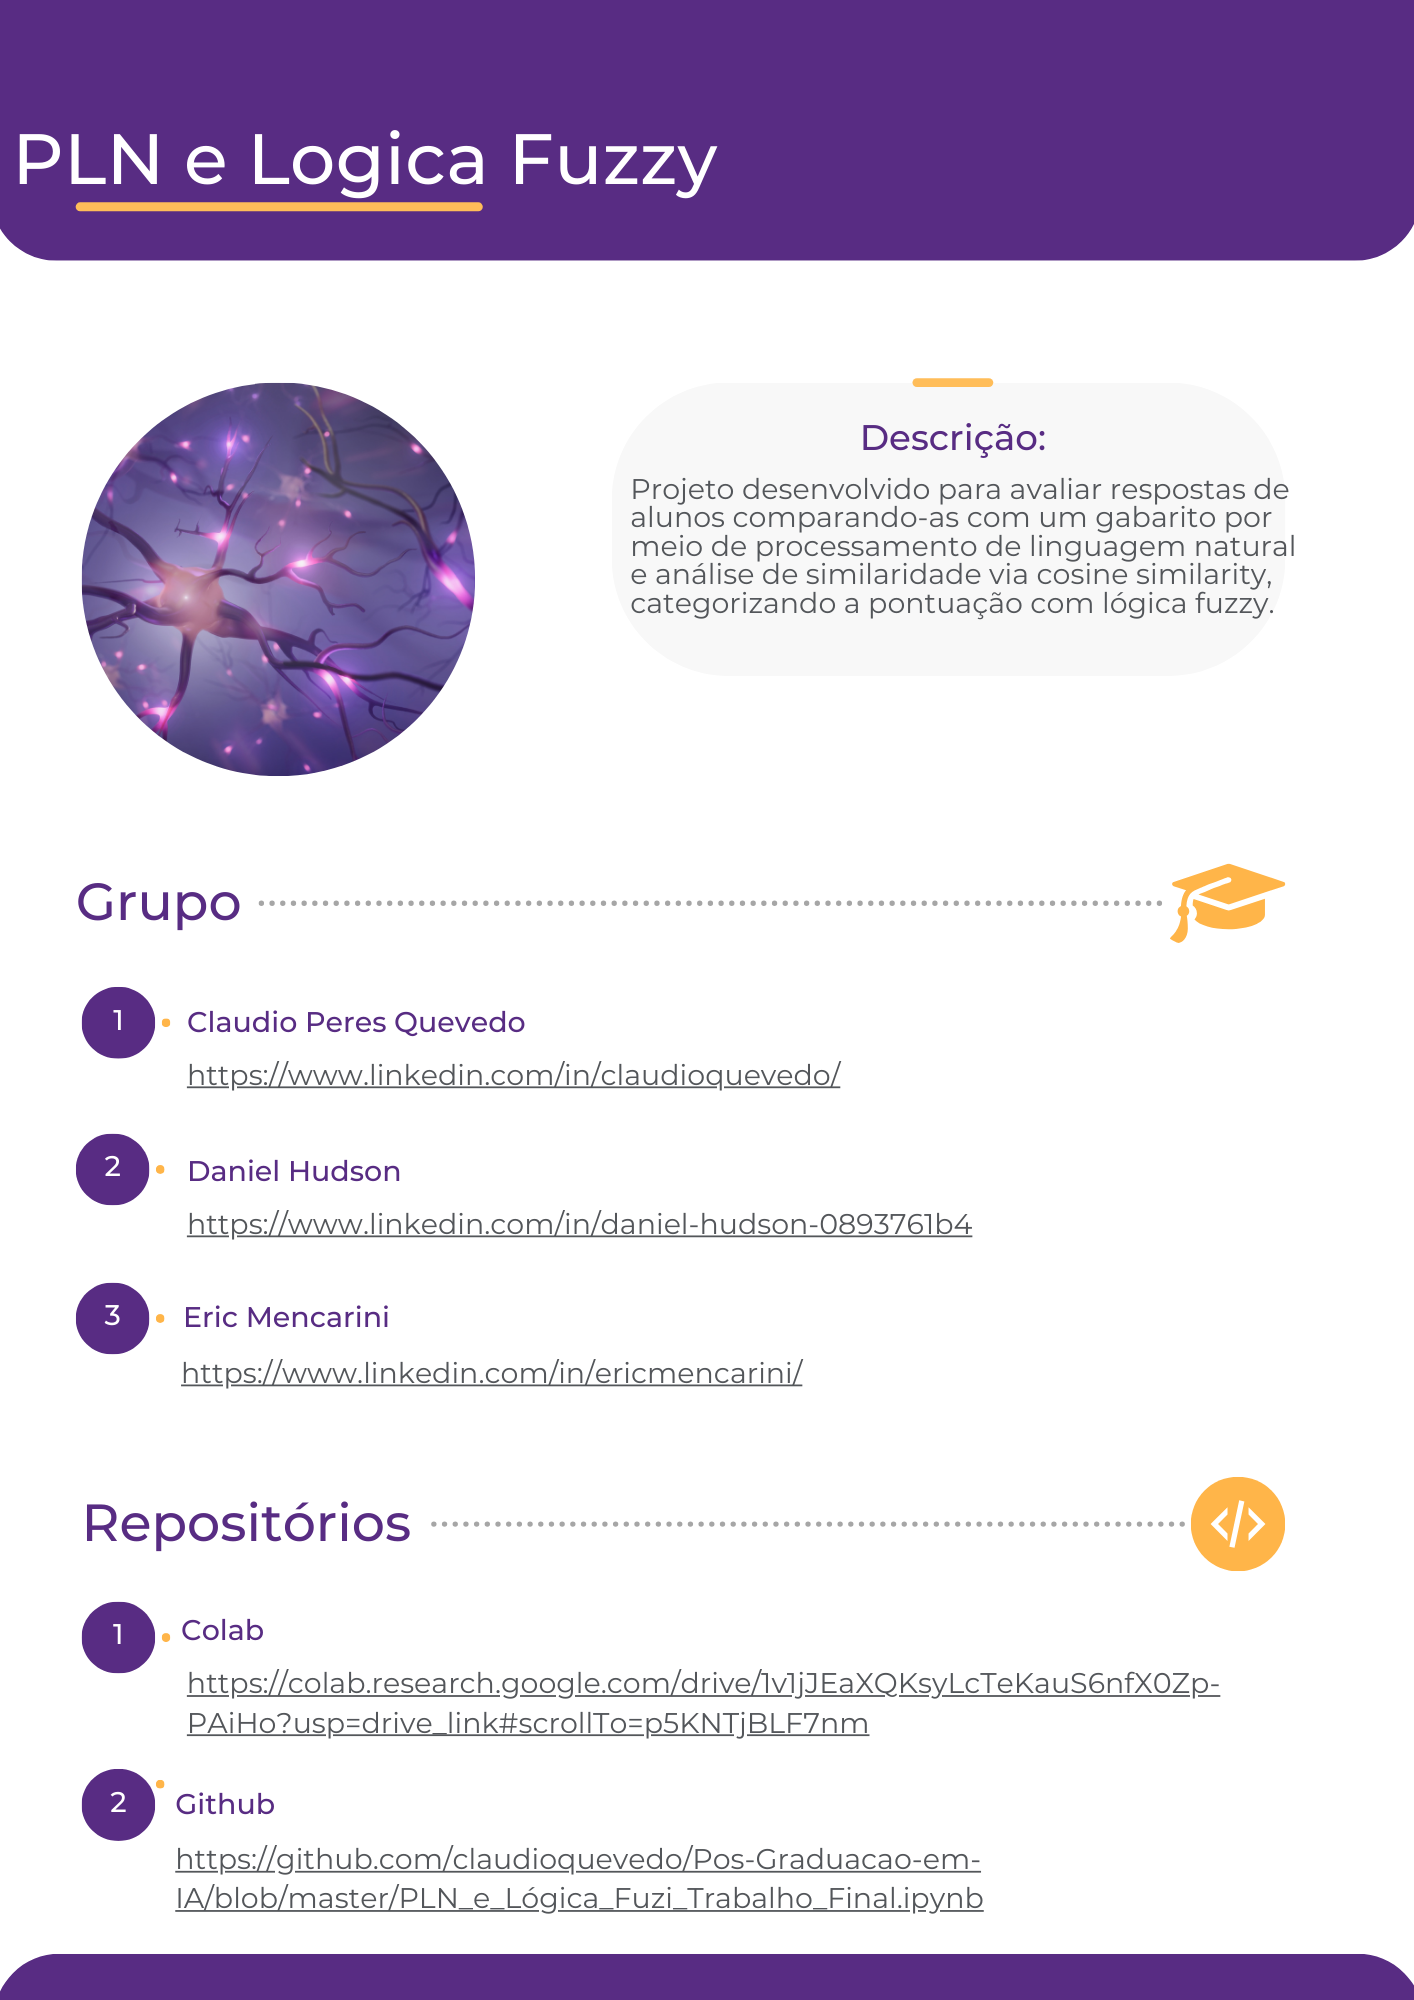

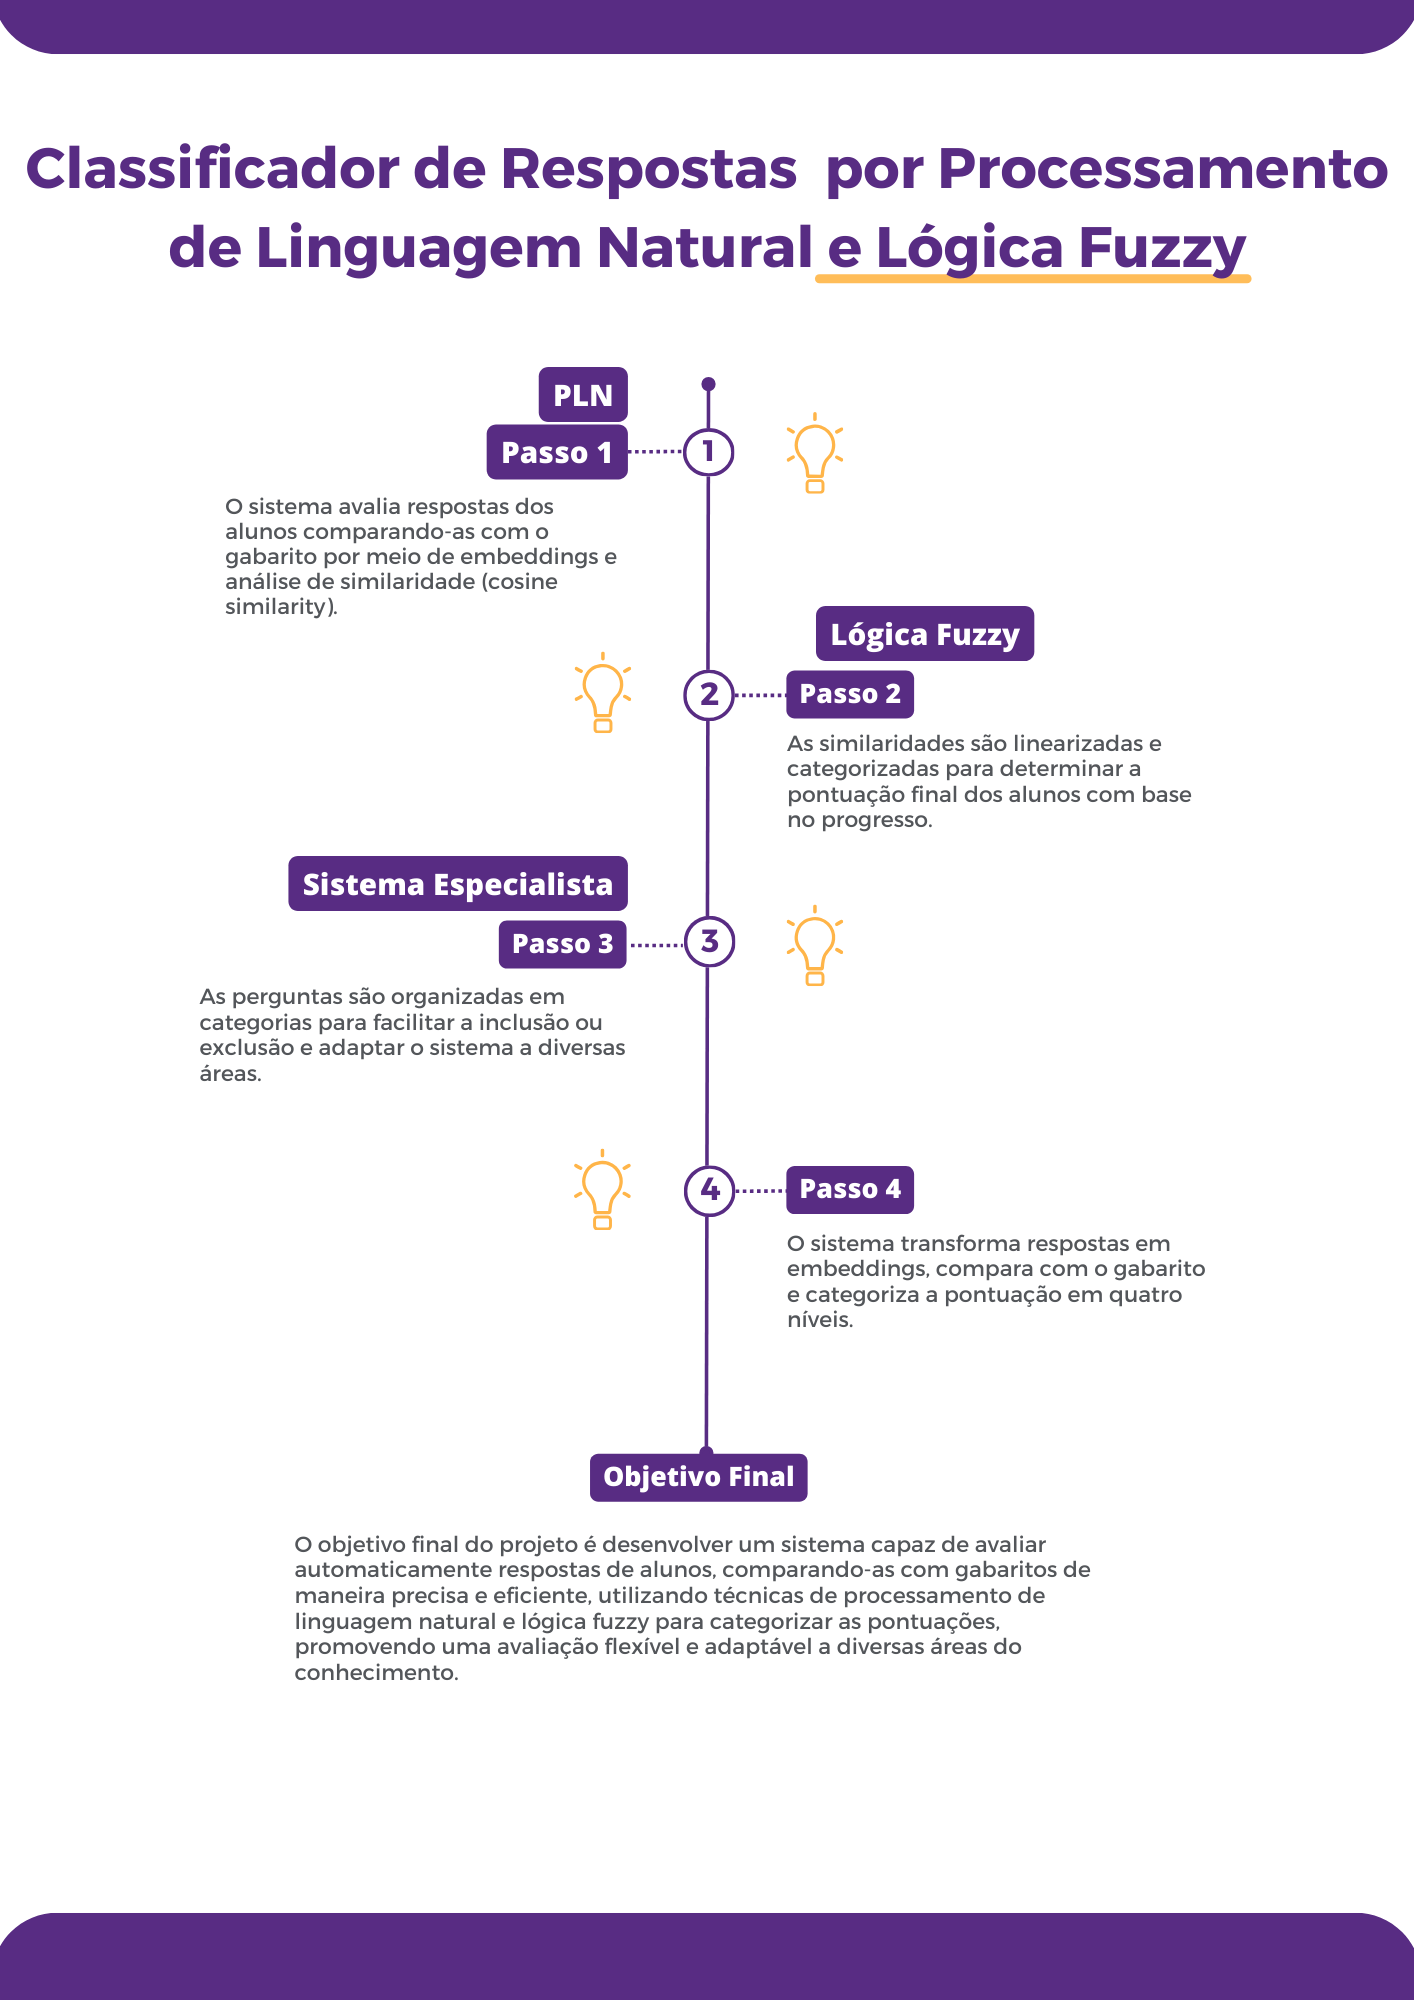

# **Sistema Especialista - Avaliação de Conhecimentos Fotográficos**

In [ ]:
# @title Instalação e importação de frameworks
#!pip install tensorflow

# Realiza as importações dos frameworks necessários
import IPython
import numpy as np
import os
import warnings
import logging
import sys
import torch

!pip install transformers torch sentence-transformers
!pip install sentence-transformers
!pip install transformers

from IPython.display import display
from IPython.display import HTML
from enum import Enum
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity


warnings.filterwarnings('ignore')

In [ ]:
# @title Classe de exibição de textos formatados
# Classe para escrever texto formatado
class MessageType(Enum):
  mtTitulo      = "font-size:18px; font-weight:bold; color:#C6E5FF; text-decoration: underline; line-height: 3;"
  mtCabecalho   = "font-size:16px; font-weight:bold; color:#C6E5FF; text-decoration: underline; line-height: 2;"
  mtPergunta    = "color: #AAD3FF; line-height: 1.5;"
  mtTipPergunta = "color: #C0C0C0; font-size:10px; font-style: italic"
  mtResultado   = "color: #AAD3FF; font-style: italic;"
  mtErro        = "color:#EB564B; "
  mtNormal      = ""

class Display:
  @staticmethod
  def ShowMessage(Message: str, MessageType: MessageType):
    if MessageType == MessageType.mtNormal:
      print(Message)
    else:
      display(HTML(f'<span style="{MessageType.value}">{Message}</span>'))

In [ ]:
# @title Classes Data Transfer (DTO)
# Classe de tipo de questionário
class Questionario:
  def __init__(self, titulo: str, introducao: str):
    self.Titulo = titulo
    self.Introducao = introducao

  def __repr__(self):
    return f"Questionario(Titulo={self.Titulo}, Introducao={self.Introducao})"
#------------------------------------------------------------------------

class RespostaItem:
  def __init__(self, caption: str):
    self.Caption = caption

  def __repr__(self):
    return f"RespostaItem(Caption={self.Caption})"
#------------------------------------------------------------------------

class PerguntaItem:
  def __init__(self, index: int, caption: str, resposta: RespostaItem):
    self.Index = index
    self.Caption = caption
    self.Resposta = resposta

  def __repr__(self):
    return f"PerguntaItem(Index={self.Index}, Caption={self.Caption}, Respostas={self.Resposta})"
#------------------------------------------------------------------------

class CategoriaPergunteItem:
  def __init__(self, index: int, caption: str, peso: float, perguntas: list[PerguntaItem]):
    self.Index = index
    self.Caption = caption
    self.Peso = peso
    self.Perguntas = perguntas

  def __repr__(self):
    return f"CategoriaPergunteItem(Index={self.Index}, Caption={self.Caption}, Peso={self.Peso}, Perguntas={self.Perguntas})"
#------------------------------------------------------------------------

class RespostaAlunoItem:
  def __init__(self, categoria: int, pergunta: int, resposta: str):
    self.Categoria = categoria
    self.Pergunta = pergunta
    self.Resposta = resposta
    self.Correspondencia = 0;

  def __repr__(self):
    return f"RespostaAlunoItem(Categoria={self.Categoria}, Pergunta={self.Pergunta}, Resposta={self.Resposta}, Correspondencia={self.Correspondencia})"
#------------------------------------------------------------------------

class DesempenhoAlunoItem:
  def __init__(self, categoria: int, pontuacao: float, pontuacaoMaxima: float):
    self.Categoria = categoria
    self.Pontuacao = pontuacao
    self.PontuacaoMaxima = pontuacaoMaxima

  def __repr__(self):
    return f"DesempenhoAlunoItem(Categoria={self.Categoria}, Pontuacao={self.Pontuacao}, Pontuação Máxima={self.PontuacaoMaxima})"
#------------------------------------------------------------------------

class AnaliseRespostaCategoria:
  def __init__(self, categoria: int, nivel: int, mensagem: str):
    self.Categoria = categoria
    self.Nivel = nivel
    self.Mensagem = mensagem

  def __repr__(self):
    return f"AnaliseRespostaCategoria(Categoria={self.Categoria}, Nivel={self.Nivel}, Mensagem={self.Mensagem})"
#------------------------------------------------------------------------

In [ ]:
# @title Monta questionário e avaliação final
#Builder para criar o título e a descrição do questionário
class QuestionarioBuilder:
  @staticmethod
  def Build(self):
    self.DescicaoQuestionario = Questionario("Avaliação de Conhecimentos Básicos de Fotografia",
                                             "Com o intuito de avaliar suas capacidades fotográficas e o que conseguiu apreender durante\n" +
                                             "o curso básico de fotografia, além de guiá-lo no desenvolvimento de suas capacidades e ajudá-lo\n" +
                                             "a identificar seus pontos fortes e fracos, apresentamos a avaliação abaixo.\n\n" +
                                             "Leia atentamente as perguntas e as respostas e responda da melhor forma as questões propostas.\n" +
                                             "Em tempo, não pense que as questões são feitas de ""certo/errado"" ou possuem uma resposta pétrea, pois em alguns casos podem \n" +
                                             "existir várias respostas corretas, de acordo com o seu nível de conhecimento.\n\n" +
                                             "Vamos começar.")

    return self.DescicaoQuestionario
#------------------------------------------------------------------------

# Builder para criar a estrutura de perguntas
class PerguntasBuilder:
  @staticmethod
  def Build():
    listaPeguntas = [
        CategoriaPergunteItem(1, "Conceitos Básicos", 3,
                              [PerguntaItem(1, "Onde deve estar o foco em fotografias de pessoas?",
                                            RespostaItem("Deve estar sempre nos olhos da pessoa")),
                              PerguntaItem(2, "Sobre profundidade de campo, qual o efeito quando se fecha o diafragma?",
                                           RespostaItem("Quanto mais fechado o diafragma, maior a profundidade de campo")),
                              PerguntaItem(3, "O que é ISO?",
                                           RespostaItem("Medida da sensibilidade do sensor à luz que chega até ele")),
                              PerguntaItem(4, "Qual a unidade de medida e quais os efeitos da velocidade do obturador no resultado da foto?",
                                           RespostaItem("É representada em segundos e suas frações e tem a capacidade de congelar a cena quando alta o suficiente")),
                              PerguntaItem(5, "Qual é a letra que representa a unidade de medida da abertura do diafragma e qual o seu efeito sobre a quantidade de luz que chega ao sensor?",
                                           RespostaItem("Possui a letra f como unidade de medida e quanto menor seu valor, mais luz chega ao sensor"))
                              ]),
        CategoriaPergunteItem(2, "Composição", 2,
                              [PerguntaItem(1, "O que é a regra dos terços?",
                                            RespostaItem("É a divisão do frame em áreas de três linhas e três colunas. As intersecções das linhas imaginárias dessa divisão determina o posicionamento dos elementos da foto")),
                               PerguntaItem(2, "Como a técnica de composição utilizando ""linhas guia"" interfere na percepção do observador da fotografia?",
                                            RespostaItem("Elas sugerem inconscientemente ao observador o caminho que leva ao ponto de interesse da foto")),
                               PerguntaItem(3, "Descreva o uso da técnica da simetria:",
                                            RespostaItem("Os elementos da fotografia devem estar dispostos de forma simétrica, não importando a orientação e nem o formato da foto"))
                              ])
    ]
    return listaPeguntas
#------------------------------------------------------------------------

# Builder para criar a estrutura de análise de respostas
class ResultadosAnaliseBuilder:
  @staticmethod
  def Build():
    listaResultadoAnaliseCategoria = [AnaliseRespostaCategoria(1, 0, "Você não estudou nada, afinal de contas."),
                                      AnaliseRespostaCategoria(1, 1, "Você ainda precisa estudar muito. Todas as suas boas fotos são, de uma forma geral, \n" +
                                                                     "obra da sorte."),
                                      AnaliseRespostaCategoria(1, 2, "Você já tem um conhecimento básico e pode tirar boas fotos, mas ainda conta muito \n" +
                                                                     "com o fator ""sorte"" para conseguir fotos com alguma qualidade."),
                                      AnaliseRespostaCategoria(1, 3, "Você possui um bom conhecimento dos conceitos básicos de fotografia, o que lhe permite \n" +
                                                                     "um bom aproveitamento das fotos tiradas."),
                                      AnaliseRespostaCategoria(1, 4, "Você possui todos os conhecimentos básicos necessários para garantir uma boa fotografia, \n" +
                                                                     "embora somente esses conhecimentos não garantam uma foto sem as técnicas de composição \n" +
                                                                     "adequadas."),

                                      AnaliseRespostaCategoria(2, 0, "Você não estudou nada, afinal de contas."),
                                      AnaliseRespostaCategoria(2, 1, "Você não consegue, de forma consciente, obter boas fotografias. Ainda depende muito da sorte."),
                                      AnaliseRespostaCategoria(2, 2, "Você consegue fazer boas fotos, mas mais estudo pode garantir a sua independência da sorte."),
                                      AnaliseRespostaCategoria(2, 3, "Você já consegue ótimas fotos e de forma consciente. Com esse nível de conhecimento,o fator \n" +
                                                                     "sorte já está quase eliminado."),
                                      AnaliseRespostaCategoria(2, 4, "Você já é capaz de fazer excelentes fotografias e, embora a sorte seja uma grande aliada \n" +
                                                                     "do fotógrafo e não deva ser desprezada, suas fotos já têm o potencial de impactar somente \n" +
                                                                     "pelos seus conhecimentos.")]

    return listaResultadoAnaliseCategoria

In [ ]:
# @title Classe para ler opções de resposta
class Keyboard:
  @staticmethod
  def input():
    Display.ShowMessage("Digite sua resposta ou deixe a linha em branco para sair:", MessageType.mtTipPergunta)
    retorno = input()
    return retorno

In [ ]:
# @title Classe para analisar as respostas do aluno
class AnaliseRespostas:

  @staticmethod
  def PertinenciaLinearCrescente(x, a, b):
      if x <= a:
          return 0
      elif a < x <= b:
          return ((x - a) / (b - a))
      else:
          return 1

  @staticmethod
  def AnalisarRespostas(listaRespostasAluno: list[RespostaAlunoItem], listaPerguntas: list[CategoriaPergunteItem]):
    model = SentenceTransformer('distiluse-base-multilingual-cased')

    for respostaAluno in listaRespostasAluno:
      # obtendso a categoria e a pergunta referente à resposta
      categoria = next((obj for obj in listaPerguntas if obj.Index == respostaAluno.Categoria), None)
      pergunta = next((obj for obj in categoria.Perguntas if obj.Index == respostaAluno.Pergunta), None)

      # Obter os embeddings dos textos
      embedding_gabarito = model.encode(pergunta.Resposta.Caption, convert_to_tensor = True, batch_size=16).unsqueeze(0)
      embedding_resposta = model.encode(respostaAluno.Resposta, convert_to_tensor = True, batch_size=16).unsqueeze(0)

      similaridade = cosine_similarity(embedding_gabarito, embedding_resposta).item()
      respostaAluno.Correspondencia = AnaliseRespostas.PertinenciaLinearCrescente(similaridade, 0, 1)

In [ ]:
# @title Classe para calcular o desempenho do aluno
class DesempenhoAluno:
  @staticmethod
  def Calcular(listaRespostasAluno: list, listaPerguntas: list):
    DesempenhoAlunoLista = []

    for respostaAluno in listaRespostasAluno:
      # obtendso a categoria e a pergunta referente à resposta
      categoria = next((obj for obj in listaPerguntas if obj.Index == respostaAluno.Categoria), None)
      pergunta = next((obj for obj in categoria.Perguntas if obj.Index == respostaAluno.Pergunta), None)

      # Obtém objeto de desempenho da categoria
      desempenhoAluno = next((obj for obj in DesempenhoAlunoLista if obj.Categoria == respostaAluno.Categoria), None)

      if desempenhoAluno is None:
        desempenhoAluno = DesempenhoAlunoItem(respostaAluno.Categoria, 0, len(categoria.Perguntas) * categoria.Peso)
        DesempenhoAlunoLista.append(desempenhoAluno)

      # Calcula o desempenho do aluno
      desempenhoAluno.Pontuacao += respostaAluno.Correspondencia * categoria.Peso

    return DesempenhoAlunoLista

In [ ]:
# @title Classe para exibir os resultados da análise final
class ResultadosAnalise:
  @staticmethod
  def pertinenciaCategorica(valor, valorMaximo, numFaixas):
    # Dividir o intervalo [0, maximo] em numFaixas partes
    faixa = valorMaximo / numFaixas

    if valor <= 0:
        return 0
    for i in range(1, numFaixas + 1):
        if valor <= i * faixa:
            return i
    return numFaixas  # Se o valor for maior que valorMaximo, retorna numFaixas


  @staticmethod
  def Exibir(listaDesempenhoAluno: list, listaPerguntas: list, listaRespostas: list):
    Display.ShowMessage("Resultados", MessageType.mtTitulo)
    listaResultados = ResultadosAnaliseBuilder.Build();

    for desempenhoAluno in listaDesempenhoAluno:
      # Utiliza a função de persistência categórica para encontrar a faixa de pontos relativa à cada resultado
      numeroRespostas = sum(1 for resultado in listaResultados if resultado.Categoria == desempenhoAluno.Categoria) - 1
      nivelAluno = ResultadosAnalise.pertinenciaCategorica(desempenhoAluno.Pontuacao, desempenhoAluno.PontuacaoMaxima, numeroRespostas)

      resultado = next((obj for obj in listaResultados if obj if (obj.Categoria == desempenhoAluno.Categoria) and (obj.Nivel == nivelAluno)), None)

      # Caso ocorra algum comportamento não previsto na função de persistência, usa a mensagem 0
      if resultado is None:
        resultado = next((obj for obj in listaResultados if obj if (obj.Categoria == desempenhoAluno.Categoria) and (obj.Nivel == 0)), None)

      categoria = next((obj for obj in listaPerguntas if obj.Index == resultado.Categoria), None)
      notaAluno = np.interp(desempenhoAluno.Pontuacao, [0, desempenhoAluno.PontuacaoMaxima], [0, 10])

      # Mostra os resultados por categoria
      Display.ShowMessage(categoria.Caption, MessageType.mtCabecalho)
      Display.ShowMessage(f"Resultado: {notaAluno:.0f}", MessageType.mtResultado)
      Display.ShowMessage(chr(175) * 45, MessageType.mtPergunta)

      Display.ShowMessage(resultado.Mensagem, MessageType.mtNormal)
      Display.ShowMessage("", MessageType.mtNormal)

In [ ]:
# @title Classe que exibe o questionário e recolhe as respostas a cada pergunta

class AvaliacaoFotografo:
  def __init__(self):
    self.finalizarExecucao = False;
    self.respostasAluno = []
    self.listaPerguntas = PerguntasBuilder.Build()
    self.Introducao = QuestionarioBuilder.Build(self)
    self.DesempenhoAluno = []

  #-----------------------------------------------------------------------------
  def Le_Resposta(self):
    if self.finalizarExecucao:
      return

    retorno = Keyboard.input()

    if (retorno == "") or (retorno is None):
      self.finalizarExecucao = True

    return retorno
  #-----------------------------------------------------------------------------

  def IniciarAvaliacao(self):
    #Introdução
    Display.ShowMessage(self.Introducao.Titulo, MessageType.mtTitulo)
    Display.ShowMessage("Introdução", MessageType.mtCabecalho)
    Display.ShowMessage(self.Introducao.Introducao, MessageType.mtNormal)
    Display.ShowMessage("", MessageType.mtNormal)

    # Mostra a categoria da pergunta
    for categoria in self.listaPerguntas:
      Display.ShowMessage(categoria.Caption, MessageType.mtCabecalho)

      # Mostra a pergunta da vez
      for pergunta in categoria.Perguntas:
        Display.ShowMessage(pergunta.Caption, MessageType.mtPergunta)

        # Espera que o usuário responda
        resposta_dada = self.Le_Resposta()

        Display.ShowMessage(chr(175) * 45, MessageType.mtPergunta)

        # Sai da aplicação caso o usuário decida
        if self.finalizarExecucao:
          break
        else:
          Display.ShowMessage("", MessageType.mtNormal)

        # Guarda a resposta do aluno
        self.respostasAluno.append(RespostaAlunoItem(categoria.Index, pergunta.Index, resposta_dada))

      # End for ------------------------------------------------------------------

      if self.finalizarExecucao:
        break
      else:
        Display.ShowMessage("", MessageType.mtNormal)

    if self.finalizarExecucao:
      Display.ShowMessage("", MessageType.mtNormal)
      Display.ShowMessage("O usuário solicitou a finalização da avaliação!", MessageType.mtErro)

    # Analisa as respostas do aluno
    AnaliseRespostas.AnalisarRespostas(self.respostasAluno, self.listaPerguntas)

    # Gera desempenho do aluno
    self.DesempenhoAluno = DesempenhoAluno.Calcular(self.respostasAluno, self.listaPerguntas)

    # Mostra resultados do aluno
    ResultadosAnalise.Exibir(self.DesempenhoAluno, self.listaPerguntas, self.respostasAluno)

In [ ]:
# @title Executa a aplicação de questionário sobre conhecimentos fotográficos
#
AvaliacaoFotografo().IniciarAvaliacao()

Com o intuito de avaliar suas capacidades fotográficas e o que conseguiu apreender durante
o curso básico de fotografia, além de guiá-lo no desenvolvimento de suas capacidades e ajudá-lo
a identificar seus pontos fortes e fracos, apresentamos a avaliação abaixo.

Leia atentamente as perguntas e as respostas e responda da melhor forma as questões propostas.
Em tempo, não pense que as questões são feitas de certo/errado ou possuem uma resposta pétrea, pois em alguns casos podem 
existir várias respostas corretas, de acordo com o seu nível de conhecimento.

Vamos começar.



Deve estar sempre nos olhos da pessoa


Não sei


Não sei


Não sei


Não sei


Não sei


Não sei


Não sei


Você ainda precisa estudar muito. Todas as suas boas fotos são, de uma forma geral, 
obra da sorte.



Você não consegue, de forma consciente, obter boas fotografias. Ainda depende muito da sorte.

